# Azure Evaluation On Audio Length

1. Compute Audio Length for Each Transcription
2. Compute Error
3. Generate Plots
***
### Error Metrics
1. WER
2. ROUGE

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

***

# Imports & Ingestion of Data
**We will be using the data generated from `azure-stu-eval.ipynb`.**

In [3]:
import pandas as pd
import numpy as np
import scipy 
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 

cols = list(pd.read_csv("net_aigenerated_data_azure_performance_stu.csv", nrows=1))
print(cols)

net_aigenerated_data_azure = pd.read_csv('/projectnb/ds549/projects/AImpower/azure-evals/net_aigenerated_data_azure_performance_stu.csv', delimiter=',', usecols =[i for i in cols if "Unnamed:" not in i])

['Unnamed: 0', 'Filename', 'Start_time', 'End_time', 'Azure', 'WER', 'Stutterance_Count', 'NA_Count', 'NA_Cleaned_Count', 'rouge1-precision', 'rouge1-recall', 'rouge1-f1', 'rouge2-precision', 'rouge2-recall', 'rouge2-f1', 'rougel-precision', 'rougel-recall', 'rougel-f1']


In [6]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [7]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [8]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [9]:
## Assign back the cleaned transcript and original transcript
merged_data = net_aigenerated_data_azure.merge(
    net_data[['Filename', 'Start_time', 'Cleaned_Transcript', 'Transcript']],
    on=['Filename', 'Start_time'],
    how='left'
)

net_aigenerated_data_azure['Cleaned_Transcript'] = merged_data['Cleaned_Transcript']
net_aigenerated_data_azure['GroundTruth_Transcript'] = merged_data['Transcript']

In [10]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1,Cleaned_Transcript,GroundTruth_Transcript
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...,0.072165,1.0,470,0,0.948718,0.973684,0.961039,0.850000,0.836066,0.842975,0.942857,0.942857,0.942857,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,我说出来就比较的需要时间，哦，然后那个嗯/i识别的它的就是它等你一会儿，你那个话还没有说完，...
1,D0001_A,790.130000,796.580000,电视剧。,0.600000,1.0,470,0,1.000000,0.285714,0.444444,0.000000,0.000000,0.000000,1.000000,0.285714,0.444444,电视剧有，我说的话。,电视剧有，我/r说的话。
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？,0.875000,10.0,470,0,0.750000,0.096774,0.171429,0.666667,0.050000,0.093023,0.750000,0.071429,0.130435,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,这/b部剧是不怎么，评分是不怎么好的，呃/i就因为呃/i评/r/b论区的那[那]些人，他们都...
3,D0001_A,2016.780000,2035.673559,很很精准，对。,0.868421,7.0,470,0,0.800000,0.200000,0.320000,0.600000,0.107143,0.181818,0.666667,0.129032,0.216216,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,很[很/b]精准，对，呃/i讯飞语音还是讯飞助手来着，就[就]我记得它是叫讯/r飞，我之前就...
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。,0.882353,8.0,470,0,1.000000,0.212121,0.350000,0.125000,0.022727,0.038462,0.777778,0.142857,0.241379,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,一个那个是嗯/i叫啥来着，我忘了，就是出现了另/r/b一个人，然后呢他[他]就射/p了一把剑...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。,0.090909,0.0,470,0,0.857143,1.000000,0.923077,0.666667,0.800000,0.727273,0.857143,1.000000,0.923077,单曲循环歌曲这样而已。,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影。,0.000000,0.0,470,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,杨幂的电影。,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？,0.200000,0.0,470,0,0.625000,0.625000,0.625000,0.428571,0.375000,0.400000,0.625000,0.555556,0.588235,你好，米雅，今天柴油价怎么样。,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。,0.166667,0.0,470,0,0.833333,0.833333,0.833333,0.600000,0.600000,0.600000,0.833333,0.833333,0.833333,单曲循环歌曲琉璃光之歌。,单曲循环歌曲琉璃光之歌。


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in ```net_data``` and AI predicted transcriptions in ```net_aigenerated_data_azure```**

In [11]:
## SAVING

net_aigenerated_data_azure.to_csv('net_aigenerated_data_azure_performance_stu.csv', sep=',')

***

## Compute Audio Length

In [12]:
net_aigenerated_data_azure = net_aigenerated_data_azure.assign(Duration=net_aigenerated_data_azure['End_time']-net_aigenerated_data_azure['Start_time'])

***

## Visualization of Scores

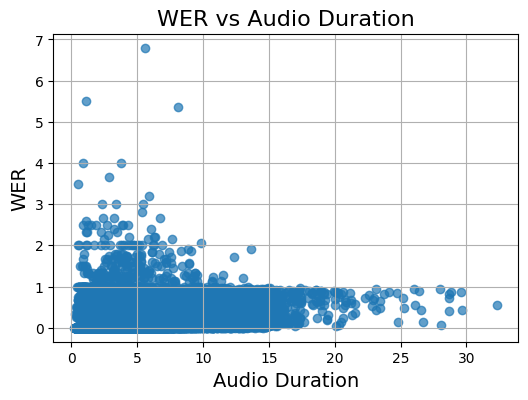

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Duration"], 
    net_aigenerated_data_azure["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [14]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Duration'], net_aigenerated_data_azure.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = 0.35815463551141125


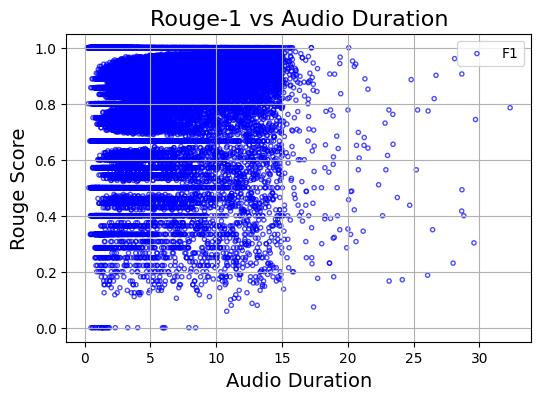

In [17]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Duration"], 
    net_aigenerated_data_azure["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

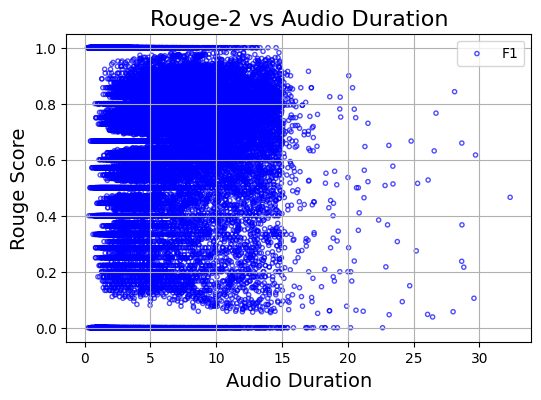

In [20]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Duration"], 
    net_aigenerated_data_azure["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

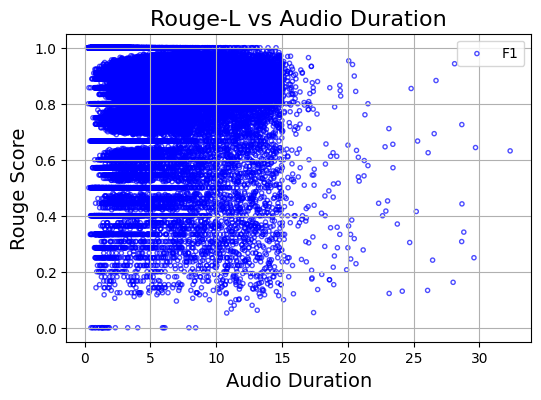

In [23]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Duration"], 
#     net_aigenerated_data_azure["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Duration"], 
    net_aigenerated_data_azure["rougel-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [24]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Duration'], net_aigenerated_data_azure.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Duration'], net_aigenerated_data_azure.dropna()['rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Duration'], net_aigenerated_data_azure.dropna()['rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = -0.2026472099019029
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = -0.2292618751483024
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = -0.29465322404547817
